## Bicycle 선수 등급 분석

공공데이터에서 제공되는 경륜 자료를 활용하여 Classification 분석을 통하여 등급을 예측하는 분석 진행

---

### Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import lightgbm as lgb
from scipy.stats import mode
import re
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from lightgbm import plot_importance
import warnings
warnings.filterwarnings('ignore')

### Data Setting

In [2]:
def Bicycle_data_setting():
    Bicycle = pd.read_csv("2016 경륜출주표.csv", encoding='cp949')
    Bicycle_y = Bicycle['등급']
    Bicycle_dum = pd.get_dummies(Bicycle.drop("등급",axis=1))
    Bicycle_total = pd.concat([Bicycle_dum, Bicycle_y], axis=1)
    
    return Bicycle_total

Bicycle_total = Bicycle_data_setting()

In [3]:
Bicycle_total.tail()

,회차,일차,경주번호,등번,기수,나이,기어배수,승률(%),연대율(%),삼연대율(%),...,최근 3회전 성적_3일차_특우12-7,최근 3회전 성적_3일차_특우14-1,최근 3회전 성적_3일차_특우14-2,최근 3회전 성적_3일차_특우14-3,최근 3회전 성적_3일차_특우14-4,최근 3회전 성적_3일차_특우14-5,최근 3회전 성적_3일차_특우14-6,최근 3회전 성적_3일차_특우14-7,최근 3회전 성적_3일차_후 보,등급
15119,51,2,15,3,19,30,3.93,28,42,58,...,0,0,0,0,0,0,0,0,0,특선
15120,51,2,15,4,17,31,3.92,12,19,33,...,0,0,0,0,0,0,0,0,0,특선
15121,51,2,15,5,18,29,3.92,17,27,38,...,0,0,0,0,0,0,0,0,0,특선
15122,51,2,15,6,21,28,3.92,28,71,79,...,0,0,0,0,0,0,0,0,0,특선
15123,51,2,15,7,12,37,3.92,11,26,39,...,0,0,0,0,0,0,0,0,0,특선


In [4]:
Bicycle_total['등급'].value_counts()

우수    6163
선발    5243
특선    3718
Name: 등급, dtype: int64

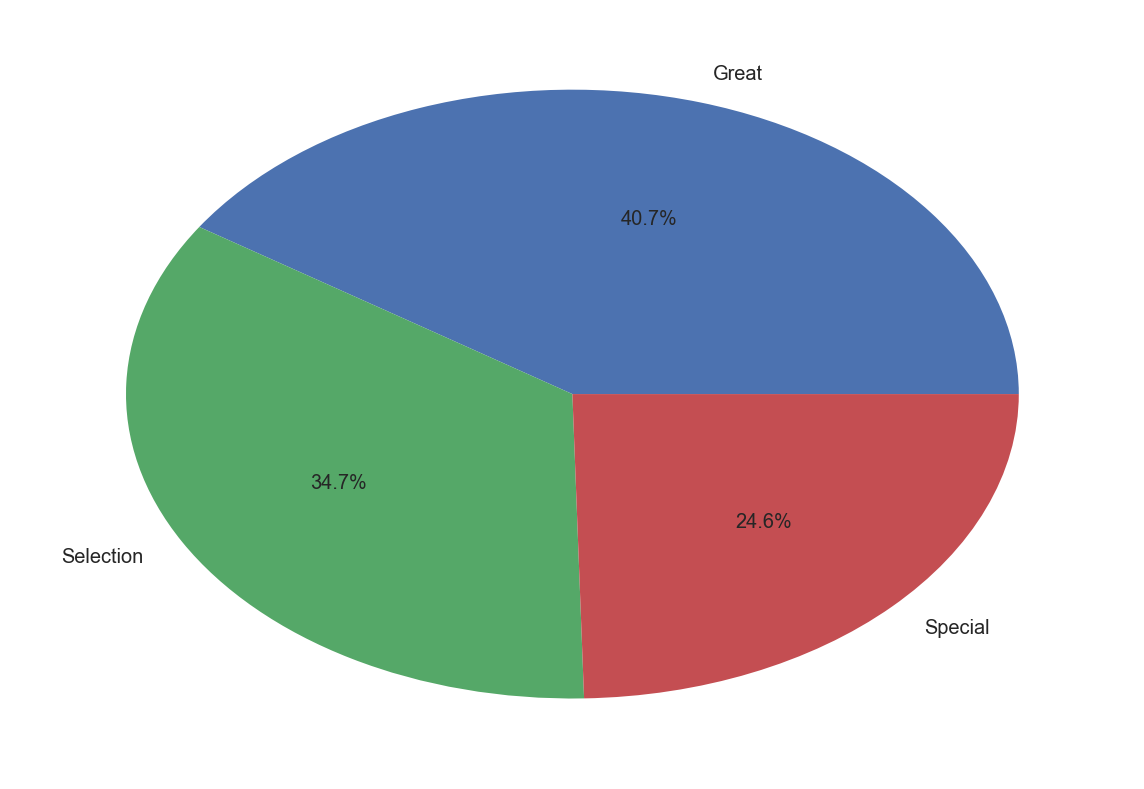

In [7]:
# 구성 비율 체크 (Pie chart)

total_v = Bicycle_total['등급'].value_counts()
fig = plt.figure(figsize = (10,7))
labels = ['Great','Selection','Special']
plt.pie(total_v, labels=labels ,autopct='%1.1f%%')
plt.show()

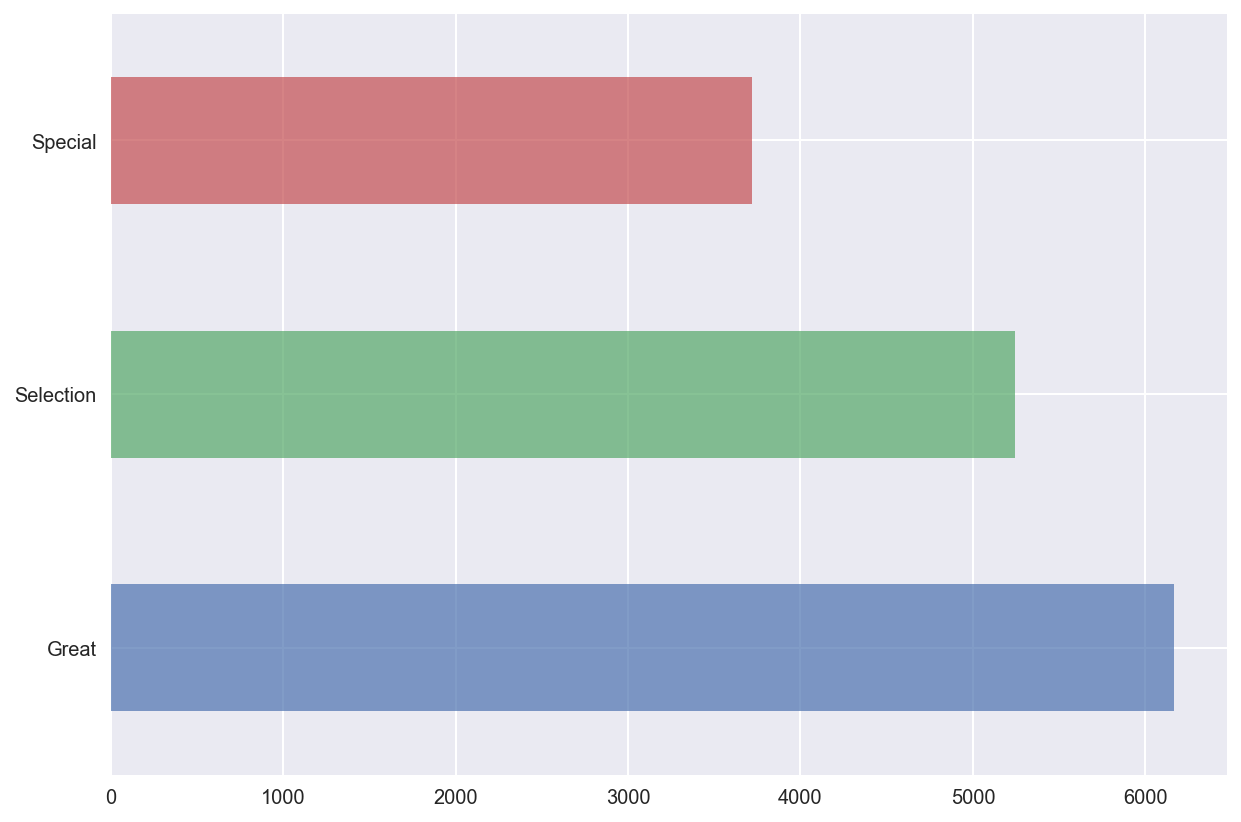

In [8]:
# 구성 비율 체크 (Bar chart)

total_v_s = pd.Series({'Great':6163,'Selection':5243,'Special':3718})
fig = plt.figure(figsize = (10,7))
total_v_s.plot(kind="barh", align='center', alpha=0.7)
plt.show()

---

### 1. 분석

In [9]:
# 데이터 split

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(Bicycle_total.drop("등급", axis=1), Bicycle_total['등급'], \
                                                    test_size=0.3, random_state=0)

len(X_train_B),len(X_test_B),len(y_train_B),len(y_test_B)

(10586, 4538, 10586, 4538)

In [10]:
# Parameter 조절하며 log-loss 체크

le = LabelEncoder()

y_train = le.fit_transform(Bicycle_total['등급'])
X_train = Bicycle_total.drop("등급", axis=1)

print("Start1")
model_1 = lgb.LGBMClassifier(nthread=3)
scores_1 = cross_val_score(estimator=model_1, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_1.mean(), scores_1.std() * 2), '-> None')
print("End")
print(" ")

print("Start2")
model_2 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5)
scores_2 = cross_val_score(estimator=model_2, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_2.mean(), scores_2.std() * 2), '-> reg_alpha=0.5')
print("End")
print(" ")

print("Start3")
model_3 = lgb.LGBMClassifier(nthread=3, reg_alpha=1)
scores_3 = cross_val_score(estimator=model_3, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_3.mean(), scores_3.std() * 2), '-> reg_alpha=1')
print("End")
print(" ")

print("Start4")
model_4 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
scores_4 = cross_val_score(estimator=model_4, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_4.mean(), scores_4.std() * 2), '-> reg_alpha=0.5, l_r=0.05, n_estimator=200')
print("End")
print(" ")

print("Start5")
model_5 = lgb.LGBMClassifier(nthread=3, reg_alpha=1, learning_rate=0.05, n_estimator=300)
scores_5 = cross_val_score(estimator=model_5, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_5.mean(), scores_5.std() * 2), '-> reg_alpha=1, l_r=0.05, n_estimator=300')
print("End")
print(" ")

print("Trial_Error")
model_6 = lgb.LGBMClassifier(nthread=3, n_estimators=200)
scores_6 = cross_val_score(estimator=model_6, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_6.mean(), scores_6.std() * 2), '-> n_estimator=200')
print("End")
print(" ")

Start1
log_loss: -0.02 (0.04) -> None
End
 
Start2
log_loss: -0.02 (0.05) -> reg_alpha=0.5
End
 
Start3
log_loss: -0.03 (0.05) -> reg_alpha=1
End
 
Start4
log_loss: -0.03 (0.05) -> reg_alpha=0.5, l_r=0.05, n_estimator=200
End
 
Start5
log_loss: -0.03 (0.05) -> reg_alpha=1, l_r=0.05, n_estimator=300
End
 
Trial_Error
log_loss: -0.02 (0.04) -> n_estimator=200
End
 


Train 

Confusion_Matrix 

[[3631    0    0]
 [   0 4318    0]
 [   0    0 2637]] 


Classification_Report 

             precision    recall  f1-score   support

         선발       1.00      1.00      1.00      3631
         우수       1.00      1.00      1.00      4318
         특선       1.00      1.00      1.00      2637

avg / total       1.00      1.00      1.00     10586
 


Accuracy_Score 

1.0 




Test 

Confusion_Matrix 

[[1612    0    0]
 [   0 1845    0]
 [   0    0 1081]] 


Classification_Report 

             precision    recall  f1-score   support

         선발       1.00      1.00      1.00      1612
         우수       1.00      1.00      1.00      1845
         특선       1.00      1.00      1.00      1081

avg / total       1.00      1.00      1.00      4538
 


Accuracy_Score 

1.0


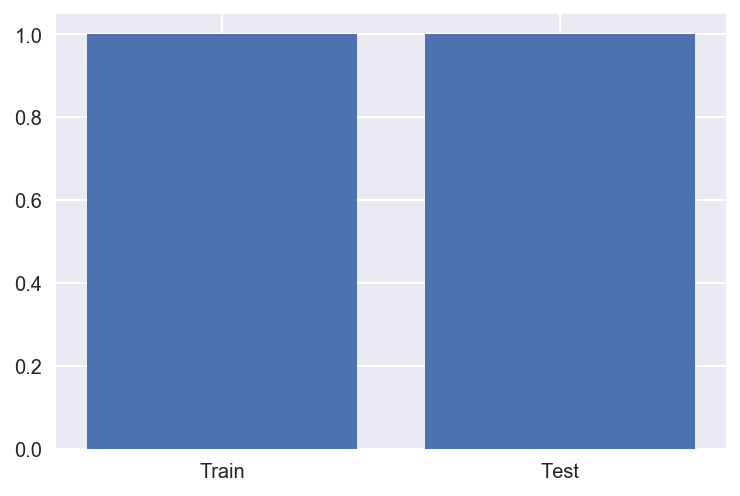

In [47]:
# def Bicycle_lgb():
    
model_lgb = lgb.LGBMClassifier(nthread=3, n_estimator=200)
model_lgb.fit(X_train_B, y_train_B)

y_pred_l = model_lgb.predict(X_train_B)

print("Train", "\n")
print("Confusion_Matrix", "\n")
print(confusion_matrix(y_train_B, y_pred_l), "\n\n")

print("Classification_Report", "\n")
print(classification_report(y_train_B, y_pred_l), "\n\n")

print("Accuracy_Score", "\n")
print(round(accuracy_score(y_train_B, y_pred_l),2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_l_B = model_lgb.predict(X_test_B)

print("Test", "\n")
print("Confusion_Matrix", "\n")
print(confusion_matrix(y_test_B, y_pred_l_B), "\n\n")

print("Classification_Report", "\n")
print(classification_report(y_test_B, y_pred_l_B), "\n\n")

print("Accuracy_Score", "\n")
print(round(accuracy_score(y_test_B, y_pred_l_B),2))

x="Train","Test"
y=accuracy_score(y_train_B, y_pred_l), accuracy_score(y_test_B, y_pred_l_B)
plt.bar(x,y)
plt.show()

In [57]:
# importances 체크 후 100 이상만 정리

importances = model_lgb.feature_importances_
importances = pd.DataFrame(importances, columns=["importance"])

i_c = Bicycle_total.drop("등급", axis=1)
i_c = i_c.columns
i_c = pd.DataFrame(i_c, columns=["name"])
f_i = pd.concat([i_c,importances],axis=1)

f_i_BB = f_i[f_i['importance'] >= 100]

In [58]:
f_i_BB.sort_values("importance", ascending=False)

,name,importance
0,회차,913
18,평균득점_광명,894
2,경주번호,883
19,평균득점_종합,725
13,출전횟수,381
22,최근 3회전 성적_경주일자,323
173,경주일자_2016.12.23,310
1041,등급조정_현재_S3,230
7,승률(%),202
61,경주일자_2016.03.26,182


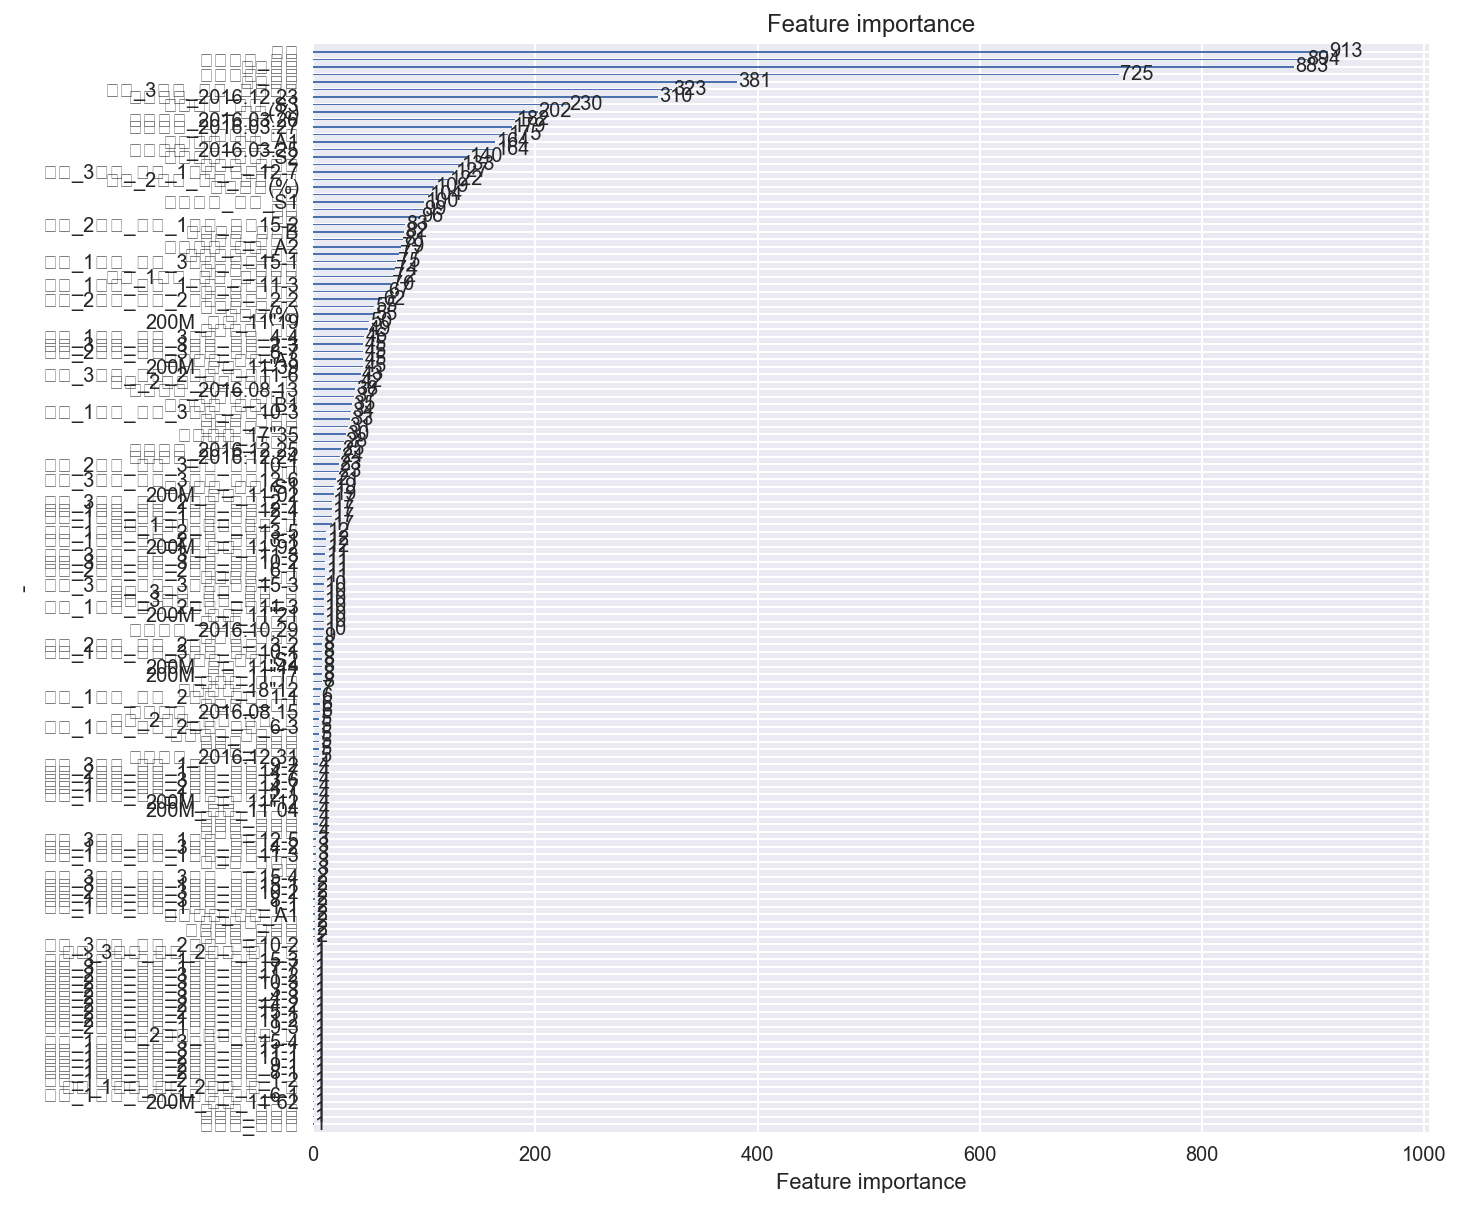

In [73]:
# importances plot

plot_importance(model_lgb, ylabel="-", figsize=(10,10))

{0, 1, 2}
['선발', '우수', '특선']


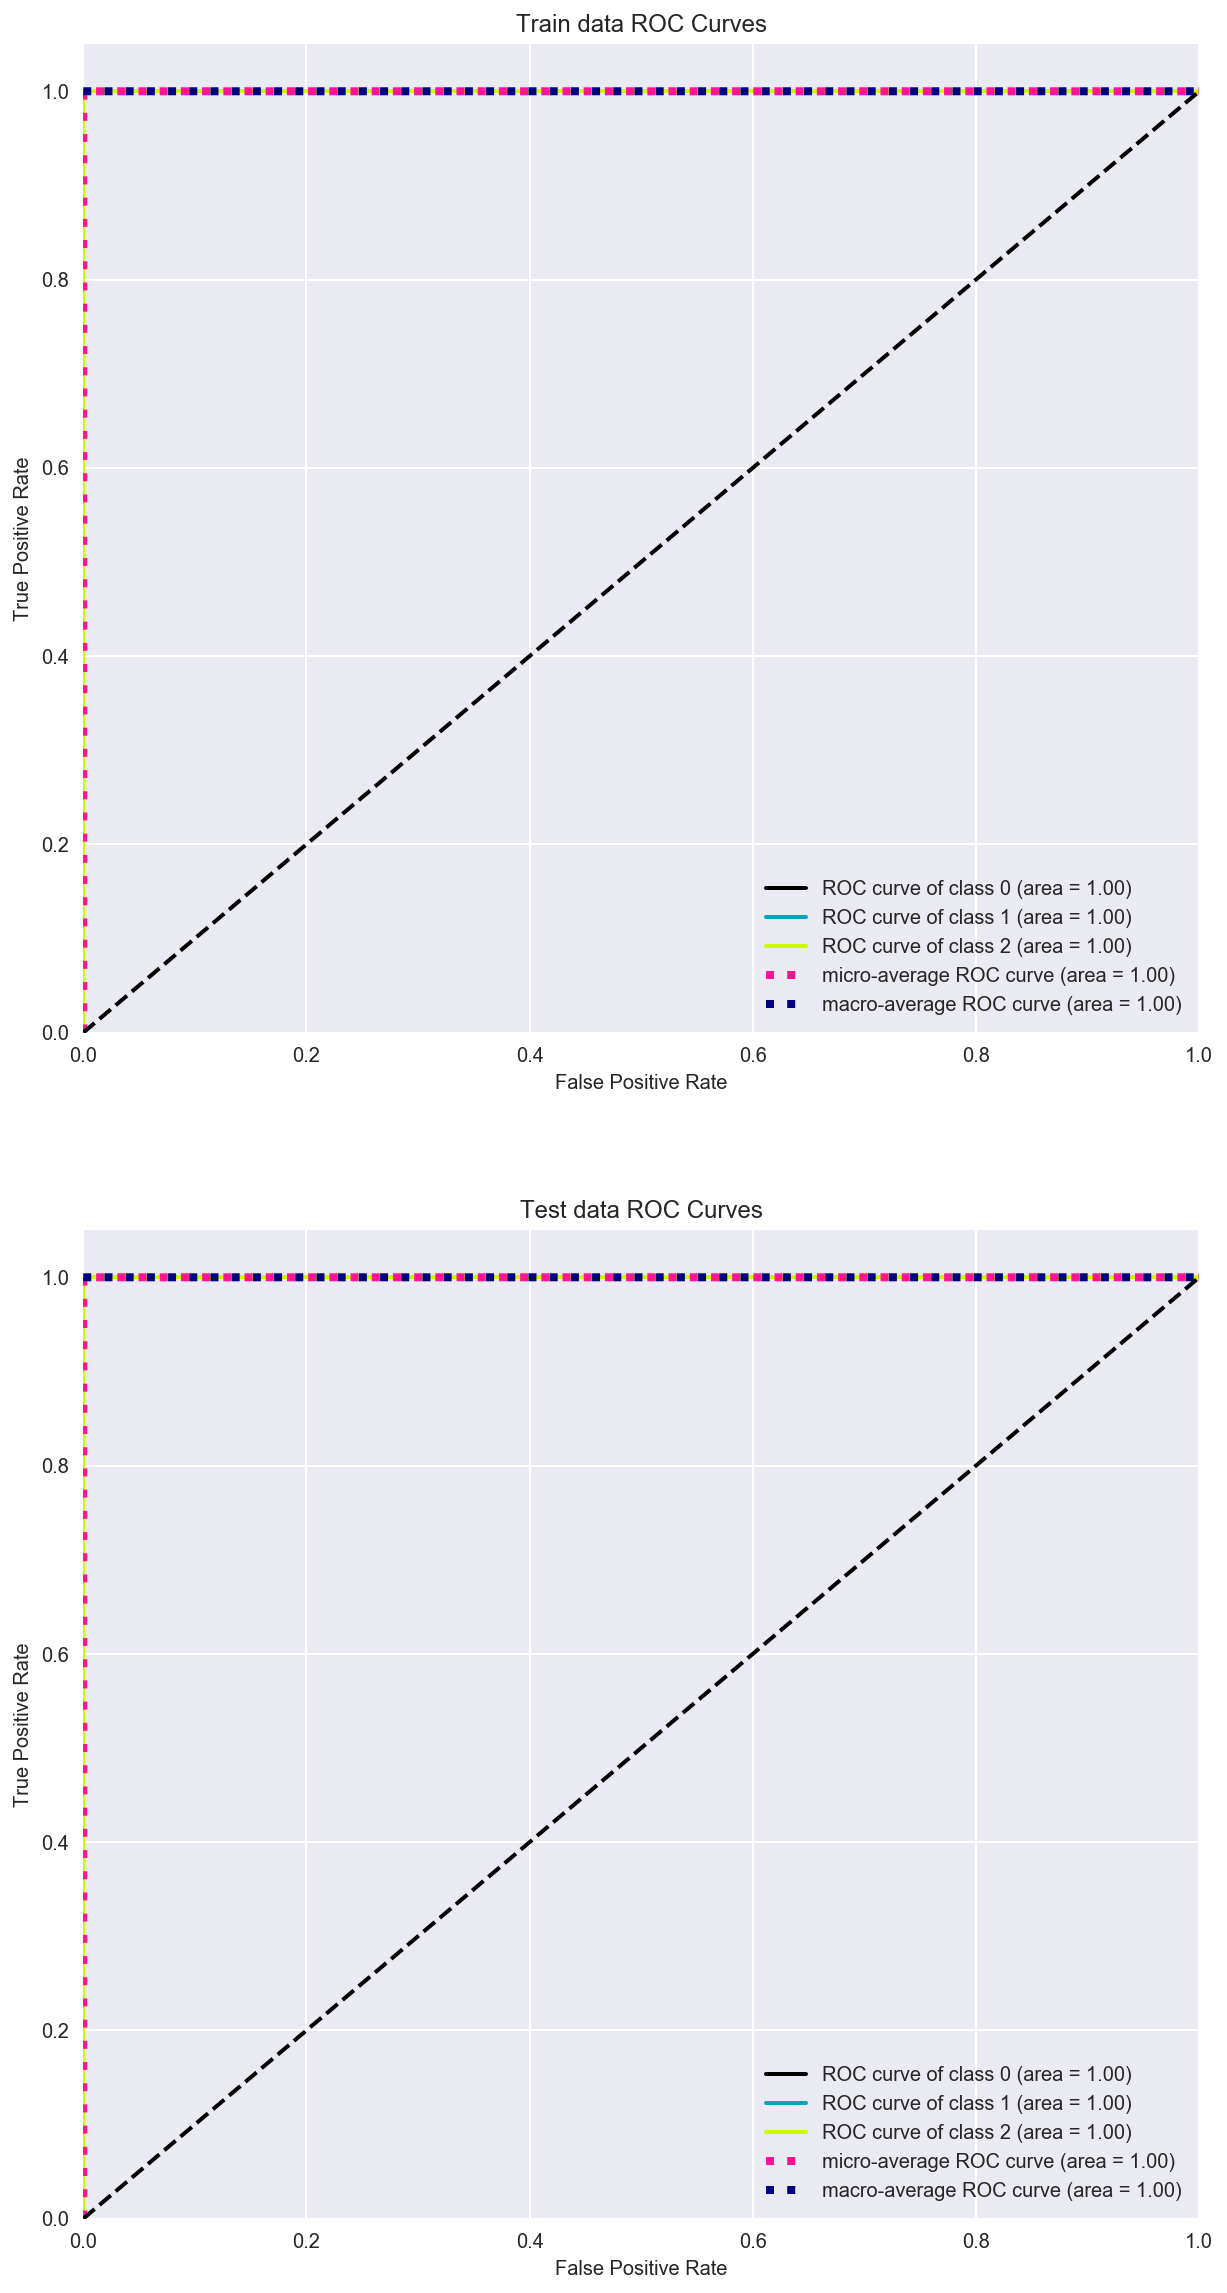

In [51]:
# ROC 민감도 체크

# Labeling
le = preprocessing.LabelEncoder()
y_label = le.fit_transform(Bicycle_total['등급'])

# re split
X_train, X_test, y_train, y_test = train_test_split(Bicycle_total.drop("등급", axis=1), y_label, \
                                                    test_size=0.4, random_state=0)

# Labeling inverse
print(set(y_label))
print(sorted(set(le.inverse_transform(y_label))))

# ROC
import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_lgb.predict_proba(X_train)
y_probas_T = model_lgb.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_train, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

---

### 2. Importance 100미만 정리 후 재 분석

In [59]:
X=Bicycle_total.drop("등급", axis=1)

f_i_B = list(f_i_BB["name"])

X_L = X.filter(f_i_B, axis=1)
y_L = Bicycle_total['등급']

In [60]:
X_L.tail()

,회차,경주번호,나이,승률(%),삼연대율(%),출전횟수,입상전법_추입,평균득점_광명,평균득점_종합,최근 2회전 성적_경주일자,...,경주일자_2016.03.25,경주일자_2016.03.26,경주일자_2016.03.27,경주일자_2016.12.23,선수명_김동관,등급조정_현재_A1,등급조정_현재_S1,등급조정_현재_S2,등급조정_현재_S3,최근 3회전 성적_1일차_특선12-7
15119,51,15,30,28,58,57,16,97.341,97.341,1202,...,0,0,0,0,0,0,0,1,0,0
15120,51,15,31,12,33,58,5,96.162,96.842,1202,...,0,0,0,0,0,0,0,0,1,0
15121,51,15,29,17,38,52,9,94.687,94.636,1111,...,0,0,0,0,0,0,0,0,1,0
15122,51,15,28,28,79,58,8,104.532,103.782,1125,...,0,0,0,0,0,0,1,0,0,0
15123,51,15,37,11,39,57,7,93.215,93.215,1209,...,0,0,0,0,0,0,0,0,1,0


In [61]:
y_L.tail()

15119    특선
15120    특선
15121    특선
15122    특선
15123    특선
Name: 등급, dtype: object

In [62]:
# 데이터 split

X_train_BB, X_test_BB, y_train_BB, y_test_BB = train_test_split(X_L, y_L, \
                                                    test_size=0.3, random_state=0)

len(X_train_BB),len(X_test_BB),len(y_train_BB),len(y_test_BB)

(10586, 4538, 10586, 4538)

In [63]:
# Parameter 조절하며 log-loss 체크

le = LabelEncoder()

y_train = le.fit_transform(y_L)
X_train = X_L

print("Start1")
model_1 = lgb.LGBMClassifier(nthread=3)
scores_1 = cross_val_score(estimator=model_1, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_1.mean(), scores_1.std() * 2), '-> None')
print("End")
print(" ")

print("Start2")
model_2 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5)
scores_2 = cross_val_score(estimator=model_2, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_2.mean(), scores_2.std() * 2), '-> reg_alpha=0.5')
print("End")
print(" ")

print("Start3")
model_3 = lgb.LGBMClassifier(nthread=3, reg_alpha=1)
scores_3 = cross_val_score(estimator=model_3, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_3.mean(), scores_3.std() * 2), '-> reg_alpha=1')
print("End")
print(" ")

print("Start4")
model_4 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
scores_4 = cross_val_score(estimator=model_4, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_4.mean(), scores_4.std() * 2), '-> reg_alpha=0.5, l_r=0.05, n_estimator=200')
print("End")
print(" ")

print("Start5")
model_5 = lgb.LGBMClassifier(nthread=3, reg_alpha=1, learning_rate=0.05, n_estimator=300)
scores_5 = cross_val_score(estimator=model_5, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_5.mean(), scores_5.std() * 2), '-> reg_alpha=1, l_r=0.05, n_estimator=300')
print("End")
print(" ")

print("Trial_Error")
model_6 = lgb.LGBMClassifier(nthread=3, n_estimators=200)
scores_6 = cross_val_score(estimator=model_6, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_6.mean(), scores_6.std() * 2), '-> n_estimator=200')
print("End")
print(" ")

Start1
log_loss: -0.03 (0.07) -> None
End
 
Start2
log_loss: -0.04 (0.07) -> reg_alpha=0.5
End
 
Start3
log_loss: -0.04 (0.07) -> reg_alpha=1
End
 
Start4
log_loss: -0.03 (0.05) -> reg_alpha=0.5, l_r=0.05, n_estimator=200
End
 
Start5
log_loss: -0.03 (0.05) -> reg_alpha=1, l_r=0.05, n_estimator=300
End
 
Trial_Error
log_loss: -0.05 (0.11) -> n_estimator=200
End
 


Train 

Confusion_Matrix 

[[3631    0    0]
 [   0 4318    0]
 [   0    0 2637]] 


Classification_Report 

             precision    recall  f1-score   support

         선발       1.00      1.00      1.00      3631
         우수       1.00      1.00      1.00      4318
         특선       1.00      1.00      1.00      2637

avg / total       1.00      1.00      1.00     10586
 


Accuracy_Score 

1.0 




Test 

Confusion_Matrix 

[[1612    0    0]
 [   1 1844    0]
 [   0    0 1081]] 


Classification_Report 

             precision    recall  f1-score   support

         선발       1.00      1.00      1.00      1612
         우수       1.00      1.00      1.00      1845
         특선       1.00      1.00      1.00      1081

avg / total       1.00      1.00      1.00      4538
 


Accuracy_Score 

1.0


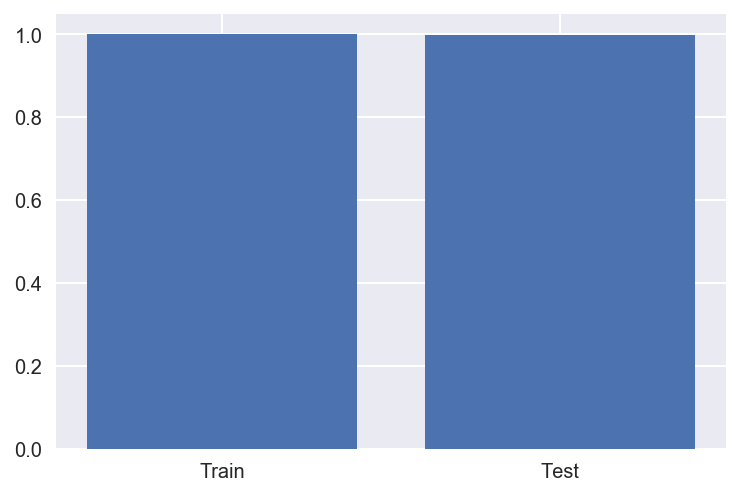

In [65]:
# def BBicycle_lgb():
    
model_lgb_f = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, l_r=0.05, n_estimator=200)
model_lgb_f.fit(X_train_BB, y_train_BB)

y_pred_l = model_lgb_f.predict(X_train_BB)

print("Train", "\n")
print("Confusion_Matrix", "\n")
print(confusion_matrix(y_train_BB, y_pred_l), "\n\n")

print("Classification_Report", "\n")
print(classification_report(y_train_BB, y_pred_l), "\n\n")

print("Accuracy_Score", "\n")
print(round(accuracy_score(y_train_BB, y_pred_l),2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_l_BB = model_lgb_f.predict(X_test_BB)

print("Test", "\n")
print("Confusion_Matrix", "\n")
print(confusion_matrix(y_test_BB, y_pred_l_BB), "\n\n")

print("Classification_Report", "\n")
print(classification_report(y_test_BB, y_pred_l_BB), "\n\n")

print("Accuracy_Score", "\n")
print(round(accuracy_score(y_test_BB, y_pred_l_BB),2))

x="Train","Test"
y=accuracy_score(y_train_BB, y_pred_l), accuracy_score(y_test_BB, y_pred_l_BB)
plt.bar(x,y)
plt.show()

In [70]:
# importances 변화 체크

importances = model_lgb_f.feature_importances_
importances = pd.DataFrame(importances, columns=["importance"])

i_c = Bicycle_total.drop("등급", axis=1)
i_c = i_c.columns
i_c = pd.DataFrame(i_c, columns=["name"])
f_i = pd.concat([i_c,importances],axis=1)

f_i_BB = f_i[f_i['importance'] >= 10]

In [71]:
f_i_BB.sort_values("importance", ascending=False)

,name,importance
1,일차,495.0
7,승률(%),387.0
8,연대율(%),359.0
0,회차,273.0
16,입상전법_추입,149.0
19,평균득점_종합,138.0
10,주회수,129.0
18,평균득점_광명,111.0
2,경주번호,93.0
14,입상전법_선행,88.0


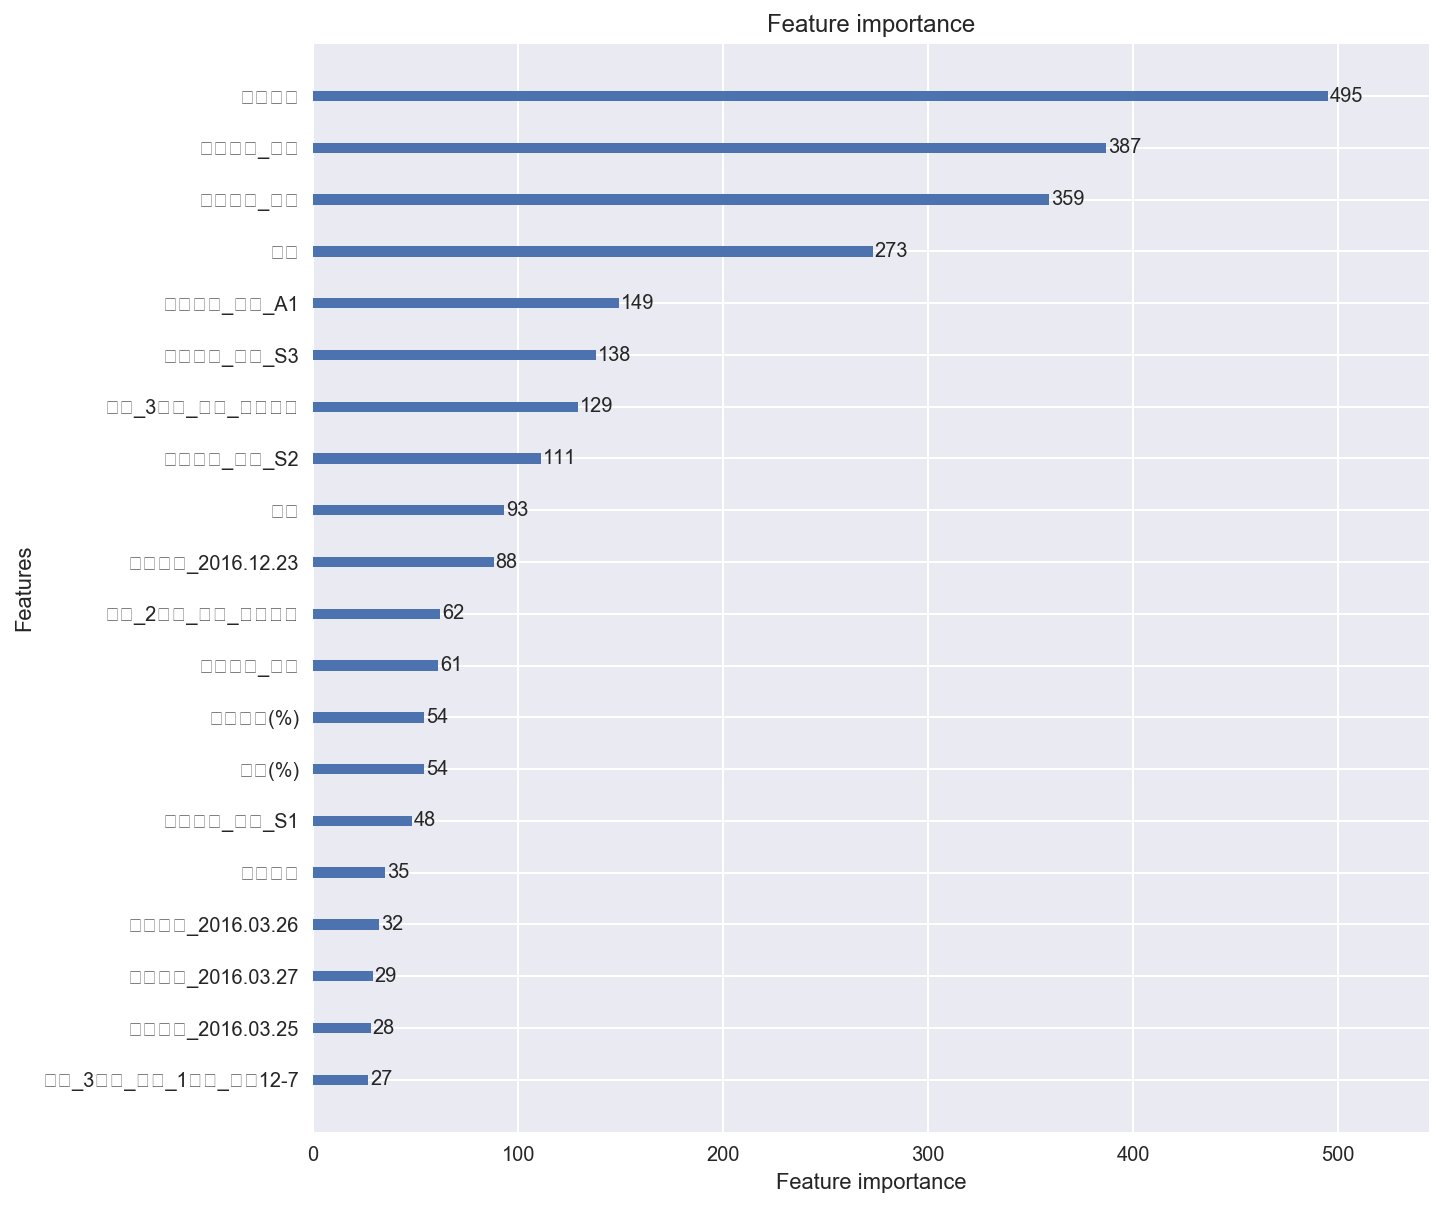

In [77]:
# importances plot

plot_importance(model_lgb_f, figsize=(10, 10))

{0, 1, 2}
['선발', '우수', '특선']


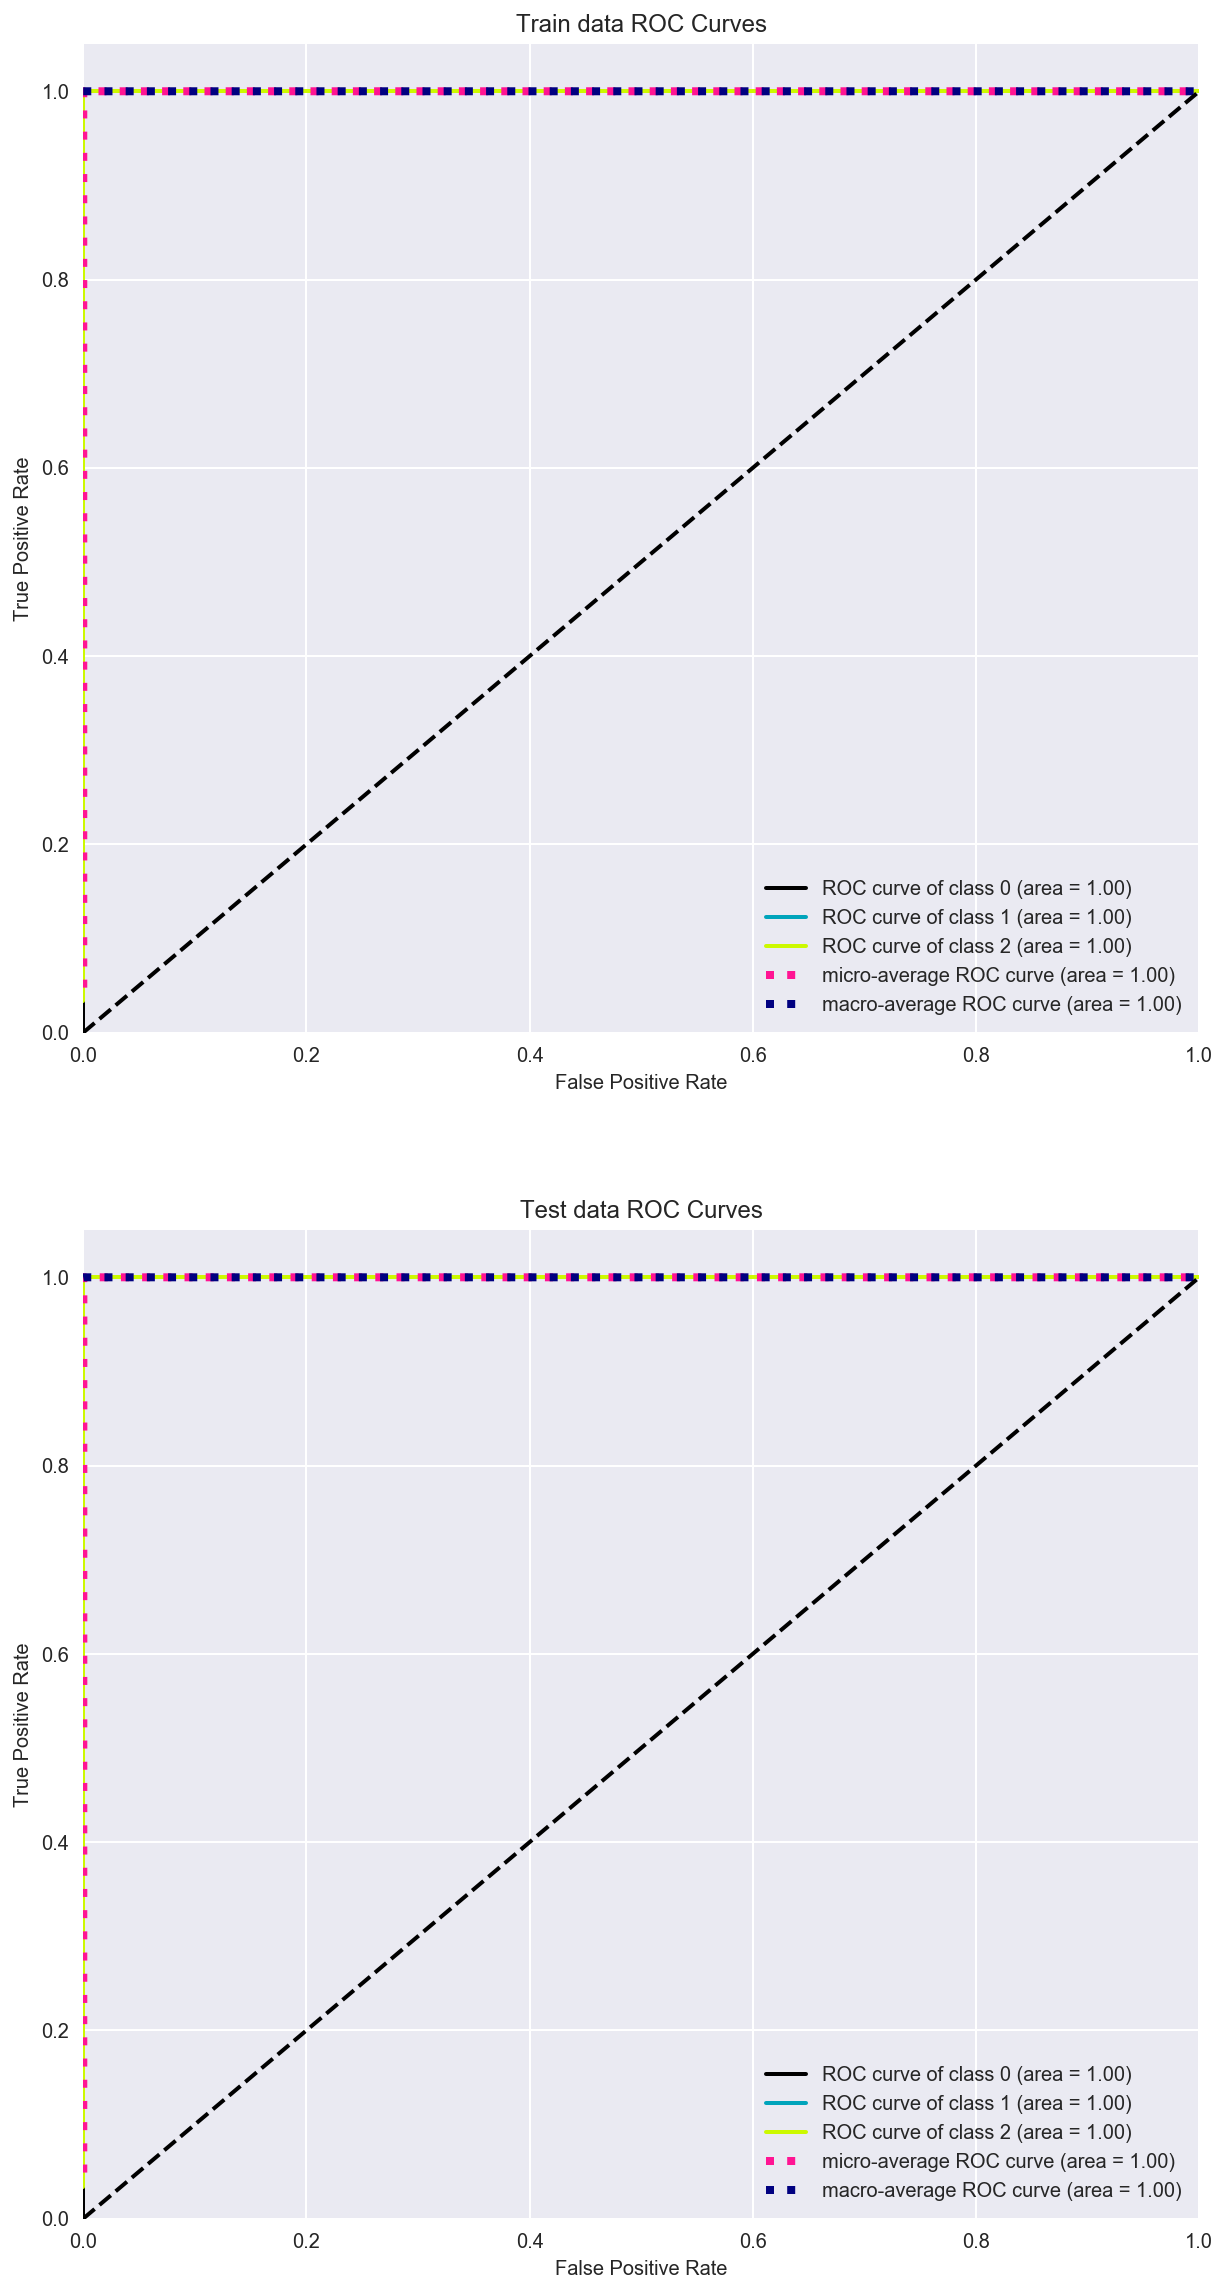

In [72]:
# ROC 민감도 체크

# Labeling
le = preprocessing.LabelEncoder()
y_label = le.fit_transform(y_L)

# re split
X_train, X_test, y_train, y_test = train_test_split(X_L, y_label, \
                                                    test_size=0.4, random_state=0)

# Labeling inverse
print(set(y_label))
print(sorted(set(le.inverse_transform(y_label))))

# ROC
import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_lgb_f.predict_proba(X_train)
y_probas_T = model_lgb_f.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_train, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

---